In [1]:
import copy
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
from matplotlib.animation import FuncAnimation
from tqdm.auto import tqdm, trange

sys.path.append("../..")
from loss import bc_derivative_mse, pde_mse
from model import Model
from preprocess import preprocess
from scheduler import CosineScheduler
from trainer import train_bc, train_ic, train_pde_data, validate

from burgers.plot import plot_1d_image
from neural_rk.modules import count_trainable_param
from neural_rk.path import DATA_DIR, FIG_DIR

rng = np.random.default_rng(42)
device = torch.device("cuda:0")

In [2]:
test_id = "1D"
sample_idx = 0
exp_id = "PINN"

df = pd.read_pickle(DATA_DIR / f"burgers_{test_id}.pkl")
data = df.iloc[sample_idx]
data

network_type                                                100_1
edge_index      [[tensor(0), tensor(1), tensor(2), tensor(3), ...
node_attr       [[tensor(1.), tensor(0.)], [tensor(1.), tensor...
edge_attr       [[tensor(0.0100), tensor(0.)], [tensor(0.), te...
glob_attr                          [[tensor(0.0100), tensor(0.)]]
dts             [[tensor(0.0010)], [tensor(0.0010)], [tensor(0...
trajectories    [[[tensor(0.9887), tensor(0.)], [tensor(0.9962...
Name: 0, dtype: object

In [3]:
# [Ny+1, Nx+1, S+1, 3], [S+1, Ny+1, Nx+1, 2], [2,]
xyt, true_field, nu = preprocess(data)

# [Nx+1, S+1, 2], [S+1, Nx+1, 1], [1,]
xt = xyt[0, :, :, (0, 2)]
true_field = true_field[:, 0, :, :1]
nu = nu[:1].to(device)


ic_sparsity = 1.0  # Sparsity of choosing grid points for initial condition
bc_sparsity = 1.0  # Sparsity of choosing grid points for boundary condition
pde_sparsity = 0.1  # Sparsity of choosing grid points for PDE condition
data_sparsity = 0.1  # Sparsity of choosing grid points for data condition
val_sparsity = 1.0  # Sparsity of choosing grid points for validation

# Full data
# Initial condition
ic_x = xt[:, 0, 0].reshape(-1, 1)
ic_t = xt[:, 0, 1].reshape(-1, 1)
ic_field = true_field[0].reshape(-1, 1)
num_ic = int(ic_sparsity * len(ic_x))

# Boundary condition. bc1: left, bc2: right
bc_x1 = xt[0, :, 0].reshape(-1, 1)
bc_t1 = xt[0, :, 1].reshape(-1, 1)
bc_x2 = xt[-1, :, 0].reshape(-1, 1)
bc_t2 = xt[-1, :, 1].reshape(-1, 1)
num_bc = int(bc_sparsity * len(bc_x1))

# PDE, data condition
pde_x = xt[..., 0].reshape(-1, 1)
pde_t = xt[..., 1].reshape(-1, 1)
pde_field = true_field.reshape(-1, 1)
num_pde = int(pde_sparsity * len(pde_x))

# Validation
val_x = xt[..., 0].reshape(-1, 1)
val_t = xt[..., 1].reshape(-1, 1)
val_field = true_field.reshape(-1, 1)
num_val = int(val_sparsity * len(val_x))


In [4]:
model = Model(in_dim=2, hidden_dim=64, out_dim=1, bn_momentum=0.5).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = CosineScheduler(
    optimizer, lr_max=1e-2, period=200, warmup=0, lr_max_mult=0.5, period_mult=2.0
)

print(f"Trainable parameters: {count_trainable_param(model)}")
print(f"Number of initial condtion points: {num_ic}")
print(f"Number of boundary condtion points: {num_bc}")
print(f"Number of pde points: {num_pde}")
print(f"Number of data points: {num_pde}")

Trainable parameters: 17216
Number of initial condtion points: 101
Number of boundary condtion points: 2001
Number of pde points: 20210
Number of data points: 20210


In [5]:
epochs = 3000

losses_ic: list[float] = []
losses_bc_value: list[float] = []
losses_bc_derivative: list[float] = []
losses_pde: list[float] = []
losses_data: list[float] = []
losses_train: list[float] = []
losses_test: list[float] = []

best_val_loss = 99999999.0
best_model_state_dict = copy.deepcopy(model.state_dict())

for epoch in trange(epochs):
    model.train()

    # Initial condition
    loss_ic = train_ic(model, ic_x, ic_t, ic_field, num_ic, device, rng)

    # Boundary condition
    loss_bc_value, loss_bc_derivative = train_bc(
        model, bc_x1, bc_t1, bc_x2, bc_t2, num_bc, device, rng
    )

    # PDE, data condition
    loss_pde, loss_data = train_pde_data(
        model, pde_x, pde_t, pde_field, num_pde, nu, device, rng
    )

    # Combining the loss functions
    loss = (
        1.0 * loss_ic
        + 0.0 * loss_bc_value
        + 0.0 * loss_bc_derivative
        + 1.0 * loss_pde
        + 1.0 * loss_data
    )

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Validation
    model.eval()
    loss_val = validate(model, val_x, val_t, val_field, num_val, device, rng).item()

    losses_ic.append(loss_ic.item())
    losses_bc_value.append(loss_bc_value.item())
    losses_bc_derivative.append(loss_bc_derivative.item())
    losses_pde.append(loss_pde.item())
    losses_data.append(loss_data.item())
    losses_train.append(loss.item())
    losses_test.append(loss_val)

    # Save best model
    if loss_val >= best_val_loss:
        continue
    best_val_loss = loss_val
    best_model_state_dict = copy.deepcopy(model.state_dict())
    tqdm.write(f"{epoch}: train loss={loss.item():.4e}, val loss={loss_val:.4e}")

# Load best model state
last_model_state_dict = copy.copy(model.state_dict())
model.load_state_dict(best_model_state_dict)

  0%|          | 0/3000 [00:00<?, ?it/s]

0: train loss=1.7437e+00, val loss=1.5676e-01
5: train loss=1.8595e-01, val loss=1.4982e-01
9: train loss=1.3425e-01, val loss=1.3519e-01
10: train loss=1.3019e-01, val loss=1.3153e-01
12: train loss=1.3189e-01, val loss=1.3124e-01
17: train loss=1.2342e-01, val loss=1.3111e-01
18: train loss=1.2081e-01, val loss=1.2833e-01
19: train loss=1.2267e-01, val loss=1.2605e-01
20: train loss=1.2092e-01, val loss=1.2439e-01
26: train loss=1.1650e-01, val loss=1.2335e-01
27: train loss=1.2187e-01, val loss=1.2226e-01
28: train loss=1.1795e-01, val loss=1.2202e-01
36: train loss=1.1848e-01, val loss=1.2194e-01
37: train loss=1.1458e-01, val loss=1.2156e-01
38: train loss=1.1615e-01, val loss=1.2127e-01
45: train loss=1.1859e-01, val loss=1.2098e-01
46: train loss=1.1711e-01, val loss=1.2065e-01
80: train loss=1.1580e-01, val loss=1.2062e-01
81: train loss=1.1623e-01, val loss=1.2049e-01
101: train loss=1.1508e-01, val loss=1.2044e-01
102: train loss=1.1802e-01, val loss=1.2019e-01
220: train los

<All keys matched successfully>

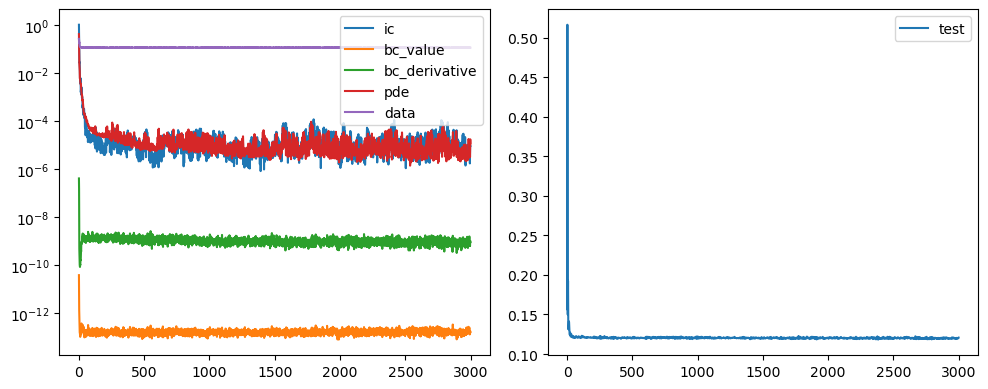

In [6]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), ncols=2)

ax1.plot(losses_ic, label="ic")
ax1.plot(losses_bc_value, label="bc_value")
ax1.plot(losses_bc_derivative, label="bc_derivative")
ax1.plot(losses_pde, label="pde")
ax1.plot(losses_data, label="data")
# ax1.plot(losses_train, label="train")

ax1.legend()
ax1.set_yscale("log")

ax2.plot(losses_test, label="test")
ax2.legend()

fig.tight_layout()
fig.show()

In [7]:
# model.load_state_dict(last_model_state_dict)

In [8]:
with torch.no_grad():
    model.eval()
    pred_trajectory = model(xt[..., 0].reshape(-1, 1).to(device), xt[..., 1].reshape(-1, 1).to(device))

# [S+1, Ny+1, Nx+1, 2]
pred_trajectory = pred_trajectory.reshape(true_field.shape).cpu().numpy()
true_trajectory = true_field.cpu().numpy()

In [9]:
error = true_trajectory - pred_trajectory
print(f"MAE={np.abs(error).mean():.4e}, in range {error.min(), error.max()}")

MAE=2.5590e-01, in range (-1.1603676, 1.1004263)


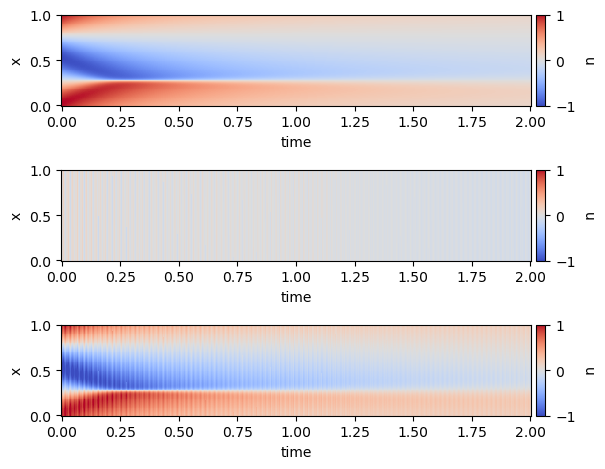

In [10]:
time = xt[0, :, 1].numpy()
position = xt[:, 0, :1].numpy()

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3)

im1 = plot_1d_image(ax1, time, position, true_trajectory, to_periodic=False, rasterized=True)
cbar = fig.colorbar(im1, ax=ax1, location="right", pad=0.01, aspect=10)
cbar.ax.set_ylabel("u", rotation=-90, va="bottom")
ax1.set_xlabel("time")
ax1.set_ylabel("x")

im2 = plot_1d_image(ax2, time, position, pred_trajectory, to_periodic=False, rasterized=True)
cbar = fig.colorbar(im2, ax=ax2, location="right", pad=0.01, aspect=10)
cbar.ax.set_ylabel("u", rotation=-90, va="bottom")
ax2.set_xlabel("time")
ax2.set_ylabel("x")

im3 = plot_1d_image(ax3, time, position, error, to_periodic=False, rasterized=True)
cbar = fig.colorbar(im3, ax=ax3, location="right", pad=0.01, aspect=10)
cbar.ax.set_ylabel("u", rotation=-90, va="bottom")
ax3.set_xlabel("time")
ax3.set_ylabel("x")

fig.tight_layout()
fig.show()